In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from geopy.distance import geodesic
from tqdm import tqdm
import shapely.speedups
from quetzal.model import stepmodel
from quetzal.io import excel

# Preparation of the transport network.
## Saves PT networks with clustered nodes.
## Needs PT networks.

In [3]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
bus = stepmodel.read_json(input_path + 'de_pt_network_bus')

In [6]:
sm = stepmodel.read_json(input_path + 'de_pt_network')

In [7]:
# Make sure to use the right zones
try:
    z = stepmodel.read_json(model_path + scenario + '/' + 'de_zones')
except FileNotFoundError:
    z = stepmodel.read_json(model_path + 'base' + '/' + 'de_zones')
#z.zones['FID'] = z.zones['NUTS_ID']
sm.zones = gpd.GeoDataFrame(z.zones)
bus.zones = gpd.GeoDataFrame(z.zones)

In [9]:
# Add reactivate links and nodes to the network, if policy is set
reasons = params['network_reactivation']['inclusion_reasons']
if isinstance(reasons, str):
    # Load rail network reactivation links and nodes
    reac_links = gpd.read_file(input_path + '/de_rail_reactivation/links.geojson')
    reac_nodes = gpd.read_file(input_path + '/de_rail_reactivation/nodes.geojson')
    
    # Adjust format to sm.links
    reac_links.drop('index', axis=1, inplace=True)
    reac_links.index = ['rs_reac_'+str(i) for i in range(len(reac_links))]
    nodes_new_index = ['rs_reac_'+str(i) for i in range(len(reac_nodes))]
    node_dict = dict(zip(reac_nodes['index'], nodes_new_index))
    reac_links['a'] = reac_links['a'].map(node_dict)
    reac_links['b'] = reac_links['b'].map(node_dict)
    reac_nodes.index = nodes_new_index
    reac_nodes['route_type'] = 'rail_short'
    reac_links['route_id'] = reac_links['trip_id']
    
    # Commpute headways from scenario settings
    reac_nodes['urbanisation'] = np.nan
    shapely.speedups.enable()
    for u in sm.zones['urbanisation'].unique():
        reac_nodes.loc[reac_nodes['geometry'].within(
            sm.zones.loc[sm.zones['urbanisation']==u, 'geometry'].unary_union
        ), 'urbanisation'] = u
    reac_nodes.loc[reac_nodes['urbanisation'].isna(), 'urbanisation'] = 3
    reac_links['urbanisation'] = reac_links['a'].map(reac_nodes['urbanisation']).astype(int)
    reac_links['headway'] = np.nan
    for u in sm.zones['urbanisation'].unique():
        reac_links.loc[reac_links['urbanisation']==u, 'headway'] = params['max_headway_urban'+str(u)]['rail_short']

    # Filter for reasons
    reasons = [s.strip() for s in reasons.split(';')]
    if reasons == list('ABCDEFGHI'):
        filtered_links = reac_links
        filtered_nodes = reac_nodes
    else:
        filtered_links = reac_links.loc[reac_links['agency_id'].apply(
            lambda s: len( set(s.split(';')).intersection(set(reasons)) ) > 0)]
        filtered_nodes = reac_nodes.loc[list(set(list(filtered_links['a']) + list(filtered_links['b'])))]
    sm.links = pd.concat([sm.links, filtered_links])[list(sm.links.columns)]
    sm.nodes = pd.concat([sm.nodes, filtered_nodes])[list(sm.nodes.columns)]
    print('Added {} rail short links due to reactivation'.format(len(filtered_links)))

## Test links and nodes for network integrity
Neccessary for any further steps

In [10]:
# FIRST: Set time of free-rider links
# Default velocity of 14 m/s for rail links
sm.links.loc[sm.links['time']==0, 'time'] = sm.links.loc[
    sm.links['time']==0, 'geometry'].apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m)) / 14
# 8 m/s for bus links
bus.links.loc[bus.links['time']==0, 'time'] = bus.links.loc[
    bus.links['time']==0, 'geometry'].apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m)) / 8

In [11]:
# Check nodeset integrity for later steps to work
try:
    sm.integrity_test_nodeset_consistency()
except AssertionError:
    print('Found {} orphan nodes'.format(len(sm.orphan_nodes)))
    sm.nodes.drop(sm.orphan_nodes, inplace=True)
    # Test integrity again
    sm.integrity_test_nodeset_consistency()

no road_links or road_nodes


In [12]:
# Test sequences
# Use an own function because quetzal's takes ages
def test_sequences(trip):
    assert len(trip)==trip['link_sequence'].max(), \
        'broken sequence in trip {}'.format(trip['trip_id'].unique()[0])

In [13]:
# Fix sequences
# Use an own function because quetzal's takes ages
def fix_sequences(trip):
    if len(trip) > 1:
        trip = trip.sort_values('link_sequence')
        # Check link succession
        ind = list(trip.index)
        for i in range(len(trip.index) - 1):
            try:
                assert trip.loc[ind[i], 'b'] == trip.loc[ind[i+1], 'a'], \
                    'broken trip {}: stop {} has no successor link'.format(
                        trip['trip_id'].unique()[0], trip.loc[ind[i], 'b'])
            except AssertionError:
                trip.loc[ind[i+1]:ind[-1], 'trip_id'] = \
                    trip.loc[ind[i+1]:ind[-1], 'trip_id'] + '_' + str(i)
        # Repair sequences
        if len(trip) != trip['link_sequence'].max():
            trip['link_sequence'] = trip.groupby('trip_id')['link_sequence'].apply(
                lambda t: [j for j in range(1, len(t.index)+1)]).sum()
    return trip

In [14]:
# Test and save broken sequences
def test_sequences_save(trip):
    if len(trip)!=trip['link_sequence'].max():
        return list(trip.index)

In [15]:
try:
    sm.links.groupby('trip_id').apply(test_sequences)
except AssertionError:
    links = sm.links.groupby('trip_id').apply(fix_sequences).reset_index(level=0, drop=True)
    links.groupby('trip_id').apply(test_sequences)
    sm.links = links

In [16]:
broken_seqs = bus.links.groupby('trip_id').apply(test_sequences_save)
if not broken_seqs is None:
    links = bus.links.loc[broken_seqs.loc[broken_seqs.notna()].sum()
                         ].groupby('trip_id').apply(fix_sequences)
    links.reset_index(level=0, drop=True, inplace=True)
    links.groupby('trip_id').apply(test_sequences)
    bus.links = pd.concat([bus.links.drop(broken_seqs.loc[broken_seqs.notna()].sum()), links])

In [17]:
assert len(bus.nodes['route_type'].unique()) == 1

In [18]:
sm.links.sample()

,route_id,route_type,a,b,time,trip_id,link_sequence,headway,geometry
index,,,,,,,,,
rs_38631,rs_31,rail_short,rs_n_1954,rs_n_1436,60.0,rs_31_15,13,3600,"LINESTRING (6.79198 51.21014, 6.80868 51.20805)"


In [19]:
sm.nodes.sample()

,stop_name,route_type,geometry
index,,,
rs_n_1476,Königstein(Sächs Schw),rail_short,POINT (14.07890 50.91945)


## Cluster nodes

Apply agglomerative clustering by zone with mode-specific distance thresholds. They determine the radius of any node cluster.

In [20]:
# Merge bus with other PT
sm.links = pd.concat([sm.links, bus.links])
sm.nodes = pd.concat([sm.nodes, bus.nodes])

In [21]:
sm.links.shape

(2171507, 9)

In [22]:
sm.nodes.shape

(410735, 3)

In [23]:
# aggregate local bus and tram, underground, ferry, funicular
if 'subway' in sm.links['route_type'].unique():
    sm.links['route_type_disagg'] = sm.links['route_type'].copy()
    sm.links['route_type'] = sm.links['route_type'].replace(
        {'tram': 'bus', 'subway': 'bus', 'ferry': 'bus', 'funicular': 'bus'})
    sm.pt_route_types = list(sm.links['route_type'].unique())

In [24]:
# Convert the coordinate system to metric, cartesian
# for the clustering algorithm to work
sm = sm.change_epsg(3857, 'meter')

Reprojecting model from epsg 4326 to epsg 3857: 100%|██████████████████████████████████| 38/38 [00:05<00:00,  6.51it/s]


In [25]:
# Cluster agglomeratively (with a cluster radius)
# by route_type and zone
nodes = []
all_nodes = gpd.GeoDataFrame(sm.nodes.copy())
links = []
all_links = gpd.GeoDataFrame(sm.links.copy())
sm.clustering_zones = sm.zones.copy()
# Process each mode seperately and concatenate tables in the end
for mode in sm.nodes['route_type'].unique():
    sm.nodes = all_nodes.loc[all_nodes['route_type']==mode]
    sm.links = all_links.loc[all_links['route_type']==mode]
    dist_col = 'radius_'+mode
    sm.clustering_zones[dist_col] = params['clustering'][dist_col]
    
    if sm.clustering_zones[dist_col].mean() != 0:
        sm.preparation_clusterize_nodes(adaptive_clustering=True, distance_col=dist_col)
        # Reindex with mode names
        prefix = ''.join([s[0] for s in mode.split('_')]) + '_'
        sm.nodes.index = [prefix + str(i) for i in sm.nodes.index]
        sm.links['a'] = prefix + sm.links['a'].apply(str)
        sm.links['b'] = prefix + sm.links['b'].apply(str)
        # Set route_type
        sm.nodes['route_type'] = mode
        
    nodes.append(sm.nodes.copy())
    links.append(sm.links.copy())
    
sm.nodes = pd.concat(nodes)
sm.links = pd.concat(links)

Mean distance threshold is 500
Mean distance threshold is 500
Mean distance threshold is 5000
Mean distance threshold is 1200


In [26]:
sm.nodes.sample()

,geometry,route_type,stop_name
b_10030000_40,POINT (1185196.552200559 7143678.399360307),bus,NaN


In [27]:
len(sm.nodes)

126997

In [28]:
# Convert the coordinate system back
sm = sm.change_epsg(4326, 'degree')

Reprojecting model from epsg 3857 to epsg 4326: 100%|██████████████████████████████████| 39/39 [00:07<00:00,  5.13it/s]


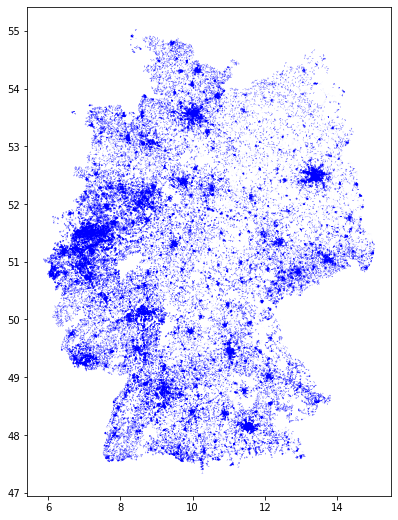

In [29]:
# Cluster coverage
if manual: gpd.GeoDataFrame(sm.node_parenthood).plot(color='blue', figsize=(9,9))

In [30]:
# Average number of stops per cluster
sm.node_clusters['count'].mean()

3.3102494925787025

## Clean
And map nodes to zones

In [31]:
# Map nodes to zones
sm.nodes = gpd.GeoDataFrame(sm.nodes, crs=sm.epsg)
shapely.speedups.enable()
sm.nodes['FID'] = np.nan
for _, zone in tqdm(sm.zones.iterrows(), total=sm.zones.shape[0]):
    sm.nodes.loc[sm.nodes['geometry'].within(zone['geometry'].buffer(1e-3)), 'FID'] = zone['FID']
len(sm.nodes.loc[sm.nodes['FID'].isna()])

100%|██████████████████████████████████████████████████████████████████████████████| 4602/4602 [01:31<00:00, 50.26it/s]


2

In [32]:
# Fill zone information of outer stops
assert len(sm.nodes[sm.nodes['FID'].isna()]) < 100
sm.nodes.loc[sm.nodes['FID'].isna(), 'FID'] = 0#sm.nodes.loc[sm.nodes['FID'].isna()].index.str[2:]

In [33]:
# Repair link geometry
geo_dict = sm.nodes['geometry'].to_dict()
sm.links['geometry'] = [geometry.LineString((geo_dict[a].coords[0], geo_dict[b].coords[0]))
                        for a,b in sm.links[['a', 'b']].values]
sm.links.shape

(2171507, 12)

In [34]:
# Drop trips with different IDs but same stop sequences
s = sm.links.groupby('trip_id').agg(tuple).drop_duplicates('a', keep='first')
sm.links = sm.links.loc[sm.links['trip_id'].isin(s.index)]
sm.links.shape

(2096074, 12)

In [35]:
# Remove within-cluster links
# Neglect time savings when small cluster distances applied
def fix_circular(trip):
    drops = trip.loc[trip['a']==trip['b']].index
    if len(drops) > 0:
        trip = trip.drop(drops).sort_values('link_sequence')
        trip['link_sequence'] = list(range(1, len(trip)+1))
    return trip

In [36]:
sm.links = sm.links.groupby('trip_id').apply(fix_circular).reset_index(level=0, drop=True)
sm.links.shape

(1599398, 12)

In [37]:
# Again: Drop trips with different IDs but same stop sequences
s = sm.links.groupby('trip_id').agg(tuple).drop_duplicates('a', keep='first')
sm.links = sm.links.loc[sm.links['trip_id'].isin(s.index)]
sm.links.shape

(1504464, 12)

In [38]:
# Integrity tests
try:
    sm.integrity_test_nodeset_consistency()
except AssertionError:
    print('Number of orphan nodes: {}'.format(
        len(sm.orphan_nodes)))
    print('Number of missing nodes: {}'.format(
        len(sm.missing_nodes)))
sm.links.groupby('trip_id').apply(test_sequences)

Number of orphan nodes: 15
Number of missing nodes: 0


""


In [39]:
# Drop orphan nodes
if len(sm.orphan_nodes) > 0: sm.nodes.drop(sm.orphan_nodes, inplace=True)

In [40]:
# Test for circular trips (quetzal's function takes too long)
def test_circular(trip):
    if len(set(list(trip['a'])+list(trip['b']))) != len(trip)+1:
        return trip

In [41]:
# Test circular trips
circular = sm.links.groupby('trip_id').apply(test_circular)
print('Number of links in circular trips: '+str(len(circular)))
print('Number of bus links in circular trips: '+str(len(circular.loc[circular['route_type']=='bus'])))

Number of links in circular trips: 388115
Number of bus links in circular trips: 387254


In [42]:
# Fix circularity issue by splitting trips
# Results in an additional interchange but prevents
# dropping a large number of connections
def fix_circular_split(trip):
    def split_trip(trip, split_by):
        split = [trip.index.get_loc(i) for i in trip.loc[trip[split_by].duplicated(keep=False)].index]
        if len(split) >= 1:
            trips = []
            # First stops
            trips.append(trip.iloc[: split[0]+1])
            # Middle stops
            for i in range(1, len(split)):
                t = trip.iloc[split[i-1]+1 : split[i]]
                t['trip_id'] = t['trip_id'] + '_' + str(i) + str(split_by)
                t['link_sequence'] = list(range(1, len(t)+1))
                trips.append(t)
            # Last stops
            t = trip.iloc[split[-1] :]
            t['trip_id'] = t['trip_id'] + '_n' + str(split_by)
            t['link_sequence'] = list(range(1, len(t)+1))
            trips.append(t)
            return pd.concat(trips)
        else:
            return trip
    # Split duplicated b stops
    trip = split_trip(trip, 'b')
    # Split duplicated a stops
    trip = trip.groupby('trip_id').apply(split_trip, 'a')
    return trip

In [43]:
fixed = circular.reset_index(level='trip_id', drop=True).groupby('trip_id').apply(fix_circular_split)
len(fixed)

364625

In [44]:
# Check that there are no circular lines anymore and the sequences are consecutive
fixed = fixed.reset_index(level='trip_id', drop=True)
fixed.groupby('trip_id').apply(test_sequences)
still_circular = fixed.groupby('trip_id').apply(test_circular)
if len(still_circular) > 0:
    fixed.drop(still_circular.reset_index(level='trip_id', drop=True).index, inplace=True)
len(fixed)

354121

In [45]:
# Replace circular lines with fixed trips
sm.links = sm.links.loc[~sm.links['trip_id'].isin(circular['trip_id'].unique())]
sm.links = pd.concat([sm.links, fixed])
len(sm.links)

1470470

In [46]:
sm.links.drop(['disaggregated_a', 'disaggregated_b'], axis=1, inplace=True)
assert len(sm.links.loc[sm.links.isna().any(axis=1)]) == 0

In [47]:
# Add bus service to ancilliary
sm.agencies = pd.concat([sm.agencies, bus.agencies]).reset_index(drop=True)
sm.pt_routes = pd.concat([sm.pt_routes, bus.pt_routes]).reset_index(drop=True)

In [48]:
# Now, we have bus services in the same tables
sm.pt_route_types = list(sm.links['route_type'].unique())
sm.pt_route_types

['air', 'bus', 'coach', 'rail_long', 'rail_short']

In [49]:
sm.links.loc[sm.links['route_type']=='rail_short'].sample()

,route_id,route_type,a,b,time,trip_id,link_sequence,headway,geometry,route_type_disagg
index,,,,,,,,,,
rs_22556,rs_196,rail_short,rs_82120000_49,rs_82120000_1,120.0,rs_196_35,15.0,43200.0,"LINESTRING (8.34117 49.02669, 8.35199 49.01561)",rail_short


## Save model


In [50]:
# Cast columns to integer
cols = ['link_sequence', 'time', 'headway']
sm.links[cols] = sm.links[cols].astype(int)

In [51]:
# Reduce nodes table size by dropping stop names
sm.nodes = sm.nodes[['FID', 'route_type', 'geometry']]
if np.issubdtype(sm.nodes['FID'].dtype, np.number):
    sm.nodes['FID'] = sm.nodes['FID'].astype(int)

In [52]:
# Split links in graph and auxiliary information
# for file sizes being compatible with github's size limit
cols = ['link_sequence', 'route_id', 'time', 'trip_id', 'headway']
auxiliary = sm.links[cols]
sm.links.drop(cols, axis=1, inplace=True)

In [53]:
# Saving model...
sm.to_json(model_path + scenario + '/' + 'de_pt_network_agg',
           only_attributes=['zones', 'links', 'nodes', 'pt_route_types'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 39/39 [07:02<00:00, 10.84s/it]


In [54]:
sm.to_json(model_path + scenario + '/' + 'de_pt_network_ancillary',
           only_attributes=['agencies', 'pt_routes', 'node_parenthood'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 39/39 [01:32<00:00,  2.37s/it]


In [55]:
# Save auxiliary information seperately
auxiliary['index'] = auxiliary.index
auxiliary.reset_index(drop=True, inplace=True)
auxiliary.to_json(model_path + scenario + '/' + 'de_pt_network_agg/links_quetzaldata.json')